### Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación

### Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones 2022
Búsqueda y Recomendación para Textos Legales

Mentor: Jorge E. Pérez Villella

# Práctico Introducción al Aprendizaje Automático

Integrantes:
* Fernando Agustin Cardellino
* Adrian Zelaya

### Objetivos:

Probar distintos modelos de clasificación para evaluar la performance y la exactitud de predicción de cada modelo. 

* Utilizando el corpus normalizado en el práctico anterior, transformar el texto en vectores numéricos utilizando scikit-learn comparando los 3 modelos de vectorización. Explicar cada uno estos modelos.

* Clasificar los documentos por fuero. Trabajaremos con los siguientes modelos de clasificación de la librería scikit-learn: Logistic Regresion, Naive Bayes y SVM. En cada modelo probar distintos hiperparámetros, generar la Matriz de Confusión y la Curva ROC. Explicar los resultados obtenidos.

* Determinar y justificar cual es el modelo con mejor performance.

* Predecir el fuero de un documento utilizando el mejor modelo.

Opcional:

* Opcional: Profundizar el tema de stop words y cómo generar uno propio.

Fecha de Entrega: 29 de julio de 2022

In [205]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import os
import spacy
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from scikitplot.metrics import plot_roc
import warnings
warnings.filterwarnings("ignore")
#import nltk
#nltk.download('stopwords')  # Descomentar para bajar las stopwords
# Ref: https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

In [206]:
# Cargamos modelo de spacy y stopwords de NLTK
nlp = spacy.load("es_core_news_sm")

CURR_DIR = os.getcwd()  # Gets current directory
STOPWORDS_ES = stopwords.words('spanish')
BREAKPOINT=None  # None para analizar todos los documentos, sino un número para analizar hasta n documentos

### Funciones que vamos a utilizar en el Práctico

#### Funciones auxiliares

In [207]:
def getListOfFiles(dirName, return_dir=False):
    # create a list of file and sub directories
    # names in the given directory
    files = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for file in files:
        # Create full path
        fullPath = os.path.join(dirName, file)
        # If entry is a directory then get the list of files in this directory
        if os.path.isdir(fullPath):
            if return_dir:
                allFiles.append(fullPath.split(os.sep)[-1])
            else:
                allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)

    return allFiles

#### Funciones específicas del análisis

In [208]:
# Funciones de preprocesamiento

def get_tokens(files_path, fuero_name=None, breakpoint=None, object_type=None):
    """
    Función que arma el corpus de palabras y las tokeniza, utilizando SpaCy.
    Si `breakpoint` != None, dar el número de docs con el que se interrumpe la función
    object_type: indica el tipo de objeto que devuelve, i.e. 'token'/None (SpaCy object `token`), 
    'word' (texto/string) or 'entity' (SpaCy object `entity`) 
    """
    def get_conditions(token, case):
        if case == 'entity':
            return True
        else:
            return token.is_alpha and not token.is_stop
    
    corpus = [] # En esta lista guardamos diccionarios con data de cada documento

    tokens = [] # En esta lista guardamos los tokens de todo el documento

    i = 0
    for filename in getListOfFiles(files_path):
        tokens_ = [] # En esta lista guardamos los tokens por documento
        file_name = filename.split(os.sep)[-1]
        # extraemos el nombre del fuero a partir de la carpeta en donde reside el documento:
        fuero = fuero_name if fuero_name is not None else filename.split(os.sep)[-2]

        with open(filename, encoding='utf-8') as file:
            file_text = file.read()
            # Tokenizamos el corpus
            nlp_doc = nlp(file_text)            
            
            iterable = nlp_doc.ents if object_type == 'entity' else nlp_doc
            
            for token in iterable:
                if get_conditions(token, case=object_type):
                    # lematizamos y pasamos a minúscula (en modo 'palabras'/'word' solamente)
                    aux_token = token.lemma_.lower() if object_type == 'word' else token
                    
                    # insertamos los tokens en la lista de todos los tokens
                    tokens.append(
                        aux_token
                    )
                    # insertamos los tokens en la lista de los tokens específicos al documento
                    tokens_.append(
                        aux_token
                    )
            # insertamos la data del documento a la lista reservada para tal fin
            corpus.append({
                'id': i, 'archivo': file_name, 'fuero': fuero, 'texto': file_text, 'texto_clean': tokens_
            })
        
        i += 1            
        # cortamos la ejecución de acuerdo al valor de quiebre (usado para testeo)
        if breakpoint:
            if i > breakpoint:
                break
    
    return tokens, pd.DataFrame(corpus)


def get_lemmas_stem_from_tokens(tokens, stemmer, language='spanish'):
    aux_dict = {
        'word': [token.lower_ for token in tokens],
        'lemma': [token.lemma_.lower() for token in tokens],
        'stem': [stemmer.stem(token.lower_) for token in tokens]
    }
    return pd.DataFrame(aux_dict)
    
    
def get_conteo_palabras(palabras):
    """Función que genera un pandas DataFrame con la frecuencia de las palabras
    """
    palabras_df = pd.DataFrame([{'palabra': str(x).lower()} for x in palabras])
    # print(corpus_df.head())

    return palabras_df.groupby(['palabra'])['palabra'].count().sort_values(ascending=False)

    
def generar_corpus(file_path, breakpoint, fuero_name=None, verbose=True, object_type='word'):
    if verbose:
        print("Generamos Corpus de palabras y conteo de frecuencias")
    
    # Generamos el corpus de palabras, y el diccionario con el mapeo de los fueros con sus respectivos documentos
    palabras, corpus = get_tokens(file_path, fuero_name=fuero_name, breakpoint=breakpoint, object_type='word')

    frecuencia_palabras_df = get_conteo_palabras(palabras)
    
    if verbose:
        print(f"Algunas palabras: {palabras[:5]}")
    
    return frecuencia_palabras_df, palabras, corpus


def vectorize_corpus(vectorizer, corpus):
    """
    Función que vectoriza un corpus de palabras compuesto por documentos, utilizando cualquier vectorizador de 
    scikit-learn que sea ingresado por el usuario.
    Se asume que el corpus ya se encuentra tokenizado (mediante la función generar_corpus()), por lo que se 'anula'
    el tokenizador por defecto de los vectorizadores.
    """
    vectorizer_ = vectorizer(
        tokenizer=lambda doc: doc, # Pisamos el tokenizador para que tome los tokens como vienen (ver descripción)
        lowercase=False # Paso ya incluido en nuestro preprocesamiento
    )
    return vectorizer_.fit_transform(corpus)

In [209]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure().clear()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')

In [238]:
def format_results(results, params):
    results_df = pd.DataFrame(results)
    cols = ['param_' + param for param in params.keys()] 
    cols += ['mean_test_score', 'std_test_score']
    results_df = results_df[cols].sort_values(by='mean_test_score',
                                              ascending=False)
    return results_df

def adjust_hyperparameters(X_train, y_train, estimator, params, cv=5,
                           print_values=False, print_results=True,
                           print_best=True, description='hyperparameter-tuning'):
    """
    This function searches for the best parameters given an estimator and 
    parameter grid values.
    """
    grid_cv = GridSearchCV(
        estimator=estimator,
        param_grid=params,
        cv=cv,
        n_jobs=50, refit=True, return_train_score=True, verbose=1)

    # Fit to the training data
    grid_cv.fit(X_train, y_train)

    best_params = grid_cv.best_params_

    if print_values:
        # Print the values used for hyperparameters
        print(f"""
        The values used for the hyperparameters:
        {grid_cv.cv_results_}
        """)

    if print_best:
        # Print best score and params
        print("\nMejor configuración:")
        display(pd.DataFrame([best_params]))
        print("\nAccuracy promedio (mejor configuración) %.3f" % grid_cv.best_score_)

    if print_results:
        results = format_results(grid_cv.cv_results_, params)
        
        best_mask = results.mean_test_score == grid_cv.best_score_
        nan_mask = results.mean_test_score.isna()
        n_nan = nan_mask.sum()
        n_best = best_mask.sum()
        print("\nAccuracy promedio y varianza para las configuraciones convergentes "
              "(ordernadas en forma descendiente):")
        display(results[~nan_mask])
        if n_best > 1:
            print(f"\nLas siguientes {n_best} configuraciones tienen el mismo 'best score':")
            display(results[best_mask])
        if n_nan > 0:
            print(f"\nLas siguientes {n_nan} configuraciones no convergieron:")
            display(results[nan_mask])
        
        # Save results
        results.to_csv(f"results_{description}.csv")

    return best_params, grid_cv.best_estimator_


def show_results(y_test, y_pred, y_prob, classes):
    
    print("Reporte de métricas de clasificación para los distintos fueros:")
    
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(cm, classes)
    
    plot_roc(y_test, y_prob)    


def run_analysis(X_train, y_train, X_test, y_test, model, parameter_grid, classes, description):
    
    best_params, best_estimator = adjust_hyperparameters(X_train, y_train, model, parameter_grid, 
                                                         cv=5, description=description)

    y_pred = best_estimator.predict(X_test)
    y_prob = best_estimator.predict_proba(X_test)
    
    show_results(y_test, y_pred, y_prob, classes)

In [211]:
# Ubicación de los documentos
filesDir = os.path.join(CURR_DIR, "Documentos")

# Obtenemos lista de los fueros
fueros = getListOfFiles(filesDir, return_dir=True)

## Generamos el corpus y tokenizamos

In [212]:
n_docs = BREAKPOINT if not None else 'todos'
    
print(f"\nAnálisis para {n_docs} documentos\n")

frecuencia_palabras_df, corpus, corpus_df = generar_corpus(filesDir, BREAKPOINT, object_type='word', verbose=False)

print(corpus[:10])

display(frecuencia_palabras_df.head())

display(corpus_df.head())


Análisis para None documentos

['sala', 'laboral', 'tribunal', 'superior', 'protocolo', 'sentencias', 'nº', 'resolución', 'año', 'tomo']


palabra
fs         4463
art        4146
ley        3121
auto       2574
recurso    2570
Name: palabra, dtype: int64

,id,archivo,fuero,texto,texto_clean
0,0,9 BAEZ-FLECHA BUS.pdf.txt,LABORAL,SALA LABORAL - TRIBUNAL SUPERIOR\n\nProtocolo ...,"[sala, laboral, tribunal, superior, protocolo,..."
1,1,90 FUNES-COYSPU.pdf.txt,LABORAL,SALA LABORAL - TRIBUNAL SUPERIOR\n\nProtocolo ...,"[sala, laboral, tribunal, superior, protocolo,..."
2,2,1 QUINTEROS-CONSOLIDAR.pdf.txt,LABORAL,SALA LABORAL - TRIBUNAL SUPERIOR\n\nProtocolo ...,"[sala, laboral, tribunal, superior, protocolo,..."
3,3,3 SANGUEDOLCE-MUNICIPALIDAD DE VILLA ALLENDE.p...,LABORAL,SALA LABORAL - TRIBUNAL SUPERIOR\n\nProtocolo ...,"[sala, laboral, tribunal, superior, protocolo,..."
4,4,188 LUCIANO-NICOLAS.pdf.txt,LABORAL,SALA LABORAL - TRIBUNAL SUPERIOR\n\nProtocolo ...,"[sala, laboral, tribunal, superior, protocolo,..."


In [213]:
print(len(corpus))

524803


# Transformación del texto en vectores numéricos

Utilizando el corpus normalizado en el práctico anterior, transformar el texto en vectores numéricos utilizando scikit-learn comparando los 3 modelos de vectorización. Explicar cada uno estos modelos.

## CountVectorizer

Este vectorizador convierte una colección de textos en una matriz de recuentos de tokens.

Para ello, primero **tokeniza** las palabras y asigna un token id (número entero) a cada token. El tokenizador por default utiliza espacios y separadores de puntuación como separadores. Luego, **cuenta** las ocurrencias de los tokens en cada documento.

El producto de salida es una matriz rala/dispersa, donde cada fila representa un documento mientras que cada columna representa un token. Los valores de la matriz representan el número de ocurrencias del token en el documento.

Referencias:
1. [sckit-learn documentation - CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
2. [sckit-learn user guide - Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) 


In [214]:
# CountVectorizer

X_1 = vectorize_corpus(CountVectorizer, corpus_df['texto_clean'])#corpus)

print(X_1.toarray())
print(X_1.toarray().shape)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(243, 18713)


## TfidfVectorizer

Este vectorizador convierte una colección de textos en una matriz de coeficientes **TF-IDF** (**T**erm-**F**requency - **I**nverse **D**ocument-**F**requency). Por la naturaleza del método, suele ser más útil en textos largos dado que para textos cortos los vectores resultantes pueden ser ruidosos/inestables. Es equivalente a utilizar el vectorizador `CountVectorizer` seguido del transformador `TfidfTransformer`.

Los coeficientes TF-IDF nos permiten balancear el peso de las palabras de acuerdo a su frecuencia de ocurrencia, dándole menos importancia a palabras que se repiten seguido y resaltando aquellas que son más inusuales/raras.

Para ello se aplica la siguiente transformación:

$\text{tf-idf}_{(t,d)} = \text{tf}_{(t,d)} * \text{idf}_{(t)}$ ,

donde $t$ corresponde a un término (token/palabra) y $d$ a un documento, además:

$\text{tf}_{(t,d)} = \frac{\text{ocurrencias de } t \text{ en } d }{\text{número de palabras en }d}$ $ $ y $ $  $\text{idf}_{(t)} = \log{\frac{1+n}{1+\text{df}_{(t)}}}$ ,

donde $n$ es el número total de documentos en el corpus y $\text{df}$ es el número de documentos que contienen el término/palabra $t$.

Finalmente, los vectores resultantes de cada documento, i.e. fila de la matriz, es normalizado utilizando la norma seleccionada (default: Euclideana o $L^2$):

$v_{norm} = \frac{v}{||v||_2} = \frac{v}{\sqrt{v{_1}^2 + v{_2}^2 + \dots + v{_n}^2}}$

Referencias:
1. [sckit-learn documentation - TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)
2. [sckit-learn user guide - Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) 

In [215]:
X_2 = vectorize_corpus(TfidfVectorizer, corpus_df['texto_clean'])


print(X_2.toarray())
print(X_2.toarray().shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(243, 18713)


## HashingVectorizer

Este vectorizador convierte una colección de textos en una matriz de ocurrencias de tokens.

Se diferencia de `CountVectorizer` en que utiliza *feature hashing*, i.e. aplica una función de hash a cada token y usa dicho hash como índice en vez de buscar los índices en alguna tabla asociativa.

Esto hace que sea un método comparativamente mucho más rápido y con un uso reducido de memoria, útil para grandes datasets.

En cuanto a sus desventajas, como no guarda registro de las características de los inputs originales, no es posible aplicar la transformación inversa, lo cual implica que no es posible saber qué características (features) pueden ser más relevantes en el modelo. 

Otro inconveniente con el método es que no permite balancear los tokens según su frecuencia de ocurrencia (IDF), aunque esto se puede suplir incluyendo un `TfidfTransformer` en el pipeline.

Por otro lado, tokens distintos pueden ser mapeados al mismo índice (hash), aunque en la práctica esto rara vez ocurre dado que el número de atributos debe ser lo suficientemente grande, e.g. $2^{18}$ para problemas de clasificación de textos.

Referencias:
1. [sckit-learn documentation - HashingVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html#sklearn.feature_extraction.text.HashingVectorizer)
2. [sckit-learn user guide - Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#vectorizing-a-large-text-corpus-with-the-hashing-trick) 
3. [Wikipedia - Feature hashing](https://en.wikipedia.org/wiki/Feature_hashing)

In [216]:
X_3 = vectorize_corpus(HashingVectorizer, corpus_df['texto_clean'])
print(X_3)

  (0, 932)	-0.10306601058361442
  (0, 6495)	0.0343553368612048
  (0, 9176)	0.0171776684306024
  (0, 9520)	0.0171776684306024
  (0, 13227)	-0.0171776684306024
  (0, 16547)	-0.0171776684306024
  (0, 18775)	0.0171776684306024
  (0, 20797)	-0.0171776684306024
  (0, 21666)	0.0343553368612048
  (0, 23868)	-0.0171776684306024
  (0, 24958)	0.0171776684306024
  (0, 25133)	-0.0171776684306024
  (0, 25678)	-0.0171776684306024
  (0, 26115)	-0.0171776684306024
  (0, 26798)	-0.0171776684306024
  (0, 30298)	-0.0171776684306024
  (0, 33190)	0.08588834215301201
  (0, 48516)	-0.15459901587542163
  (0, 49032)	-0.0171776684306024
  (0, 50569)	-0.0171776684306024
  (0, 52575)	-0.05153300529180721
  (0, 54040)	-0.05153300529180721
  (0, 54733)	-0.0171776684306024
  (0, 57213)	-0.0171776684306024
  (0, 58260)	0.0343553368612048
  :	:
  (242, 1028090)	0.005553156561650238
  (242, 1029528)	-0.005553156561650238
  (242, 1029808)	-0.011106313123300475
  (242, 1030586)	-0.005553156561650238
  (242, 1030691)	-0.02

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Clasificación de documentos por fuero

Clasificar los documentos por fuero. Trabajaremos con los siguientes modelos de clasificación de la librería scikit-learn: Logistic Regresion, Naive Bayes y SVM. En cada modelo probar distintos hiperparámetros, generar la Matriz de Confusión y la Curva ROC. Explicar los resultados obtenidos.

## Partición de los datos

In [217]:
X = vectorize_corpus(TfidfVectorizer, corpus_df['texto_clean']).toarray()

y = corpus_df.fuero.values

classes = corpus_df.fuero.unique().tolist()

# Separamos el dataset en entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Separamos el set de evaluación en testeo y validación (que guardamos para el final)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1)

print("Training set (%.1f%%): %s, %s" % (len(y_train)/len(y)*100, X_train.shape, y_train.shape))
print("Testing set (%.1f%%): %s, %s" % (len(y_test)/len(y)*100, X_test.shape, y_test.shape))
print("Validation set (%.1f%%): %s, %s" % (len(y_val)/len(y)*100, X_val.shape, y_val.shape))

Training set (70.0%): (170, 18713), (170,)
Testing set (26.7%): (65, 18713), (65,)
Validation set (3.3%): (8, 18713), (8,)


## Regresión logística

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio para

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio para

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio para

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio para

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio para

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio para

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio para

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio para

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio para

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio para

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not co


Mejor configuración:


,C,fit_intercept,penalty,solver
0,0.5,False,none,newton-cg



Accuracy promedio (mejor configuración) 0.976

Accuracy promedio y varianza para las configuraciones convergentes (ordernadas en forma descendiente):


,param_solver,param_C,param_fit_intercept,param_penalty,mean_test_score,std_test_score
271,saga,17.833333,False,none,0.976471,0.022010
207,saga,13.5,False,none,0.976471,0.022010
108,newton-cg,7.0,False,none,0.976471,0.022010
300,newton-cg,20.0,False,none,0.976471,0.022010
175,saga,11.333333,False,none,0.976471,0.022010
...,...,...,...,...,...,...
22,sag,0.5,True,l2,0.888235,0.011765
21,lbfgs,0.5,True,l2,0.888235,0.011765
20,newton-cg,0.5,True,l2,0.888235,0.011765
3,saga,0.5,False,l1,0.841176,0.023529



Las siguientes 30 configuraciones tienen el mismo 'best score':


,param_solver,param_C,param_fit_intercept,param_penalty,mean_test_score,std_test_score
271,saga,17.833333,False,none,0.976471,0.02201
207,saga,13.5,False,none,0.976471,0.02201
108,newton-cg,7.0,False,none,0.976471,0.02201
300,newton-cg,20.0,False,none,0.976471,0.02201
175,saga,11.333333,False,none,0.976471,0.02201
44,newton-cg,2.666667,False,none,0.976471,0.02201
46,sag,2.666667,False,none,0.976471,0.02201
47,saga,2.666667,False,none,0.976471,0.02201
206,sag,13.5,False,none,0.976471,0.02201
303,saga,20.0,False,none,0.976471,0.02201



Las siguientes 140 configuraciones no convergieron:


,param_solver,param_C,param_fit_intercept,param_penalty,mean_test_score,std_test_score
0,newton-cg,0.5,False,l1,NaN,NaN
1,lbfgs,0.5,False,l1,NaN,NaN
2,sag,0.5,False,l1,NaN,NaN
8,newton-cg,0.5,False,elasticnet,NaN,NaN
9,lbfgs,0.5,False,elasticnet,NaN,NaN
...,...,...,...,...,...,...
306,sag,20.0,True,l1,NaN,NaN
312,newton-cg,20.0,True,elasticnet,NaN,NaN
313,lbfgs,20.0,True,elasticnet,NaN,NaN
314,sag,20.0,True,elasticnet,NaN,NaN


Reporte de métricas de clasificación para los distintos fueros:
              precision    recall  f1-score   support

     FAMILIA       1.00      1.00      1.00        35
     LABORAL       1.00      1.00      1.00         9
     MENORES       1.00      1.00      1.00         9
       PENAL       1.00      1.00      1.00        12

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



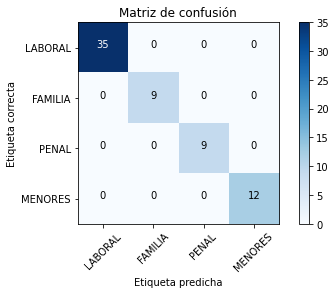

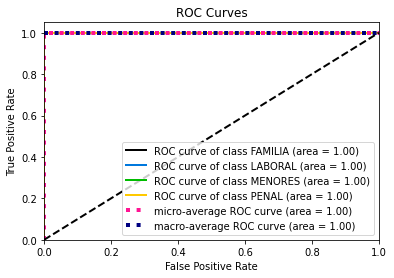

In [239]:
model = LogisticRegression(random_state=42)

parameter_grid = {
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], # For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss
    'C': np.linspace(0.5, 20, 10),
    'fit_intercept': [False, True],
    #'tol':np.linspace(0.0001, 0.001, 5),
    'penalty': ['l1', 'l2', 'elasticnet', 'none']
    
}

run_analysis(X_train, y_train, X_test, y_test, model, parameter_grid, classes, description='logistic-regression')

## Naïve Bayes

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejor configuración:


,alpha,fit_prior
0,0.05,False



Accuracy promedio (mejor configuración) 0.941

Accuracy promedio y varianza para las configuraciones convergentes (ordernadas en forma descendiente):


,param_alpha,param_fit_prior,mean_test_score,std_test_score
1,0.05,False,0.941176,0.026307
0,0.05,True,0.905882,0.011765
3,0.266667,False,0.888235,0.011765
5,0.483333,False,0.882353,0.018602
9,0.916667,False,0.876471,0.022010
17,1.783333,False,0.876471,0.022010
15,1.566667,False,0.876471,0.022010
13,1.35,False,0.876471,0.022010
11,1.133333,False,0.876471,0.022010
19,2.0,False,0.876471,0.022010


Reporte de métricas de clasificación para los distintos fueros:
              precision    recall  f1-score   support

     FAMILIA       0.95      1.00      0.97        35
     LABORAL       1.00      1.00      1.00         9
     MENORES       1.00      0.78      0.88         9
       PENAL       1.00      1.00      1.00        12

    accuracy                           0.97        65
   macro avg       0.99      0.94      0.96        65
weighted avg       0.97      0.97      0.97        65



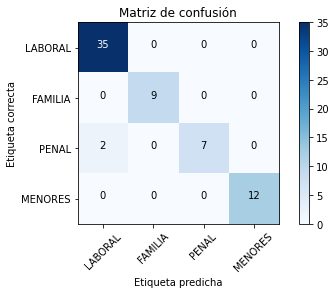

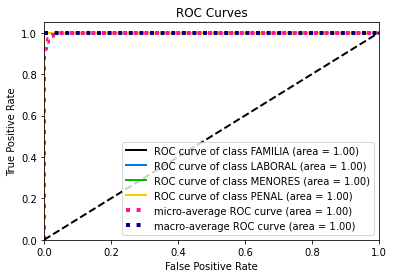

In [240]:
# Naive Bayes
model = MultinomialNB()

parameter_grid = {
    'alpha': np.linspace(0.05, 2., 10),
    'fit_prior': [True, False]
}

run_analysis(X_train, y_train, X_test, y_test, model, parameter_grid, classes, description='naive-bayes')

## SVM

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/base.py", line 666, in score
    return accuracy_score(y, self.predict(X


Mejor configuración:


,C,break_ties,decision_function_shape,gamma,kernel,shrinking
0,1.555556,True,ovr,scale,sigmoid,True



Accuracy promedio (mejor configuración) 0.971

Accuracy promedio y varianza para las configuraciones convergentes (ordernadas en forma descendiente):


,param_C,param_kernel,param_gamma,param_shrinking,param_break_ties,param_decision_function_shape,mean_test_score,std_test_score
246,3.666667,sigmoid,scale,True,False,ovr,0.970588,0.018602
278,4.722222,sigmoid,scale,True,True,ovr,0.970588,0.018602
294,4.722222,sigmoid,scale,True,False,ovo,0.970588,0.018602
182,2.611111,sigmoid,scale,True,False,ovr,0.970588,0.018602
183,2.611111,sigmoid,scale,False,False,ovr,0.970588,0.018602
...,...,...,...,...,...,...,...,...
252,3.666667,rbf,auto,True,False,ovr,0.500000,0.000000
488,7.888889,poly,auto,True,False,ovo,0.500000,0.000000
489,7.888889,poly,auto,False,False,ovo,0.500000,0.000000
249,3.666667,poly,auto,False,False,ovr,0.500000,0.000000



Las siguientes 54 configuraciones tienen el mismo 'best score':


,param_C,param_kernel,param_gamma,param_shrinking,param_break_ties,param_decision_function_shape,mean_test_score,std_test_score
246,3.666667,sigmoid,scale,True,False,ovr,0.970588,0.018602
278,4.722222,sigmoid,scale,True,True,ovr,0.970588,0.018602
294,4.722222,sigmoid,scale,True,False,ovo,0.970588,0.018602
182,2.611111,sigmoid,scale,True,False,ovr,0.970588,0.018602
183,2.611111,sigmoid,scale,False,False,ovr,0.970588,0.018602
342,5.777778,sigmoid,scale,True,True,ovr,0.970588,0.018602
535,8.944444,sigmoid,scale,False,True,ovr,0.970588,0.018602
534,8.944444,sigmoid,scale,True,True,ovr,0.970588,0.018602
598,10.0,sigmoid,scale,True,True,ovr,0.970588,0.018602
599,10.0,sigmoid,scale,False,True,ovr,0.970588,0.018602



Las siguientes 160 configuraciones no convergieron:


,param_C,param_kernel,param_gamma,param_shrinking,param_break_ties,param_decision_function_shape,mean_test_score,std_test_score
0,0.5,poly,scale,True,True,ovo,NaN,NaN
1,0.5,poly,scale,False,True,ovo,NaN,NaN
2,0.5,linear,scale,True,True,ovo,NaN,NaN
3,0.5,linear,scale,False,True,ovo,NaN,NaN
4,0.5,rbf,scale,True,True,ovo,NaN,NaN
...,...,...,...,...,...,...,...,...
587,10.0,linear,auto,False,True,ovo,NaN,NaN
588,10.0,rbf,auto,True,True,ovo,NaN,NaN
589,10.0,rbf,auto,False,True,ovo,NaN,NaN
590,10.0,sigmoid,auto,True,True,ovo,NaN,NaN


Reporte de métricas de clasificación para los distintos fueros:
              precision    recall  f1-score   support

     FAMILIA       1.00      1.00      1.00        35
     LABORAL       1.00      1.00      1.00         9
     MENORES       1.00      1.00      1.00         9
       PENAL       1.00      1.00      1.00        12

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



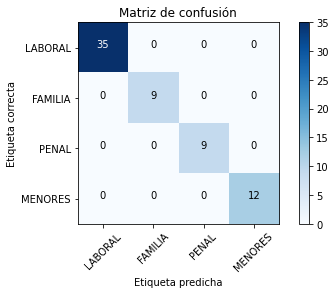

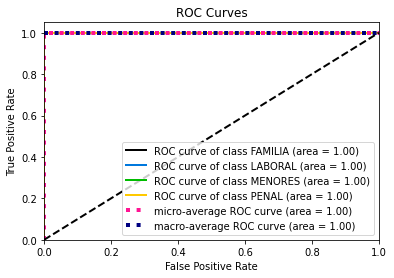

In [241]:
# SVM
from sklearn.svm import SVC
model = SVC(random_state=42, probability=True)

parameter_grid = {
    'C': np.linspace(0.5, 10., 10),
    'kernel': ['poly', 'linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'break_ties': [True, False],
    'decision_function_shape': ['ovo', 'ovr']
}

run_analysis(X_train, y_train, X_test, y_test, model, parameter_grid, classes, description='svm')

## Mejores modelos
Los mejores modelos son los siguentes:
- Logistic Regression: 97.6% de accuracy
- SVM: 97.1% accuracy

Si bien LR parece tener mayor accuracy según los resultados del grid search hyperparameter tuning, al correrlos con la data de evaluación (X_test, y_test), ambos muestran una accuracy del 100%.

Cabe mencionar que las mejores configuraciones de ambos modelos no son únicas, por lo que tuvimos que revisar si las mismas eran razonables a partir de sus respectivas documentaciones.

A continuación corremos ambos modelos con el set de validación que separamos al comienzo de este ejercicio. Ninguno de los modelos ha sido expuesto a esta data durante el entrenamiento y/o evaluación.

Vemos que para ambos modelos la accuracy es del 100%. Habrá que ver si ampliando el corpus se mantienen los mismos resultados.


Reporte de métricas de clasificación para los distintos fueros:
              precision    recall  f1-score   support

     FAMILIA       1.00      1.00      1.00         4
     LABORAL       1.00      1.00      1.00         2
     MENORES       1.00      1.00      1.00         1
       PENAL       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



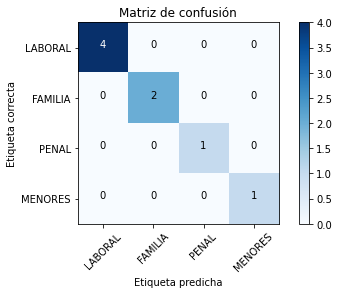

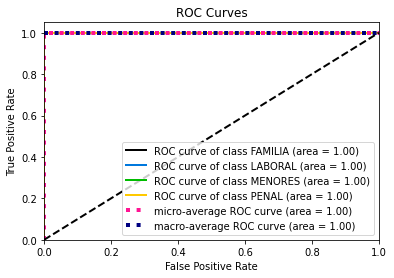

In [225]:
# SVM 

params = {
    'C': 1.56,
    'break_ties':True, # If true, decision_function_shape='ovr', and number of classes > 2, predict will break ties according to the confidence values of decision_function; otherwise the first class among the tied classes is returned. Please note that breaking ties comes at a relatively high computational cost compared to a simple predict.
    'decision_function_shape':'ovr', # Whether to return a one-vs-rest (‘ovr’) decision function of shape (n_samples, n_classes) as all other classifiers, or the original one-vs-one (‘ovo’) decision function of libsvm which has shape (n_samples, n_classes * (n_classes - 1) / 2). However, note that internally, one-vs-one (‘ovo’) is always used as a multi-class strategy to train models; an ovr matrix is only constructed from the ovo matrix. 
    'gamma': 'scale', # Kernel coefficient. Default=scale, if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
    'kernel': 'sigmoid',
    'shrinking': True, # Whether to use the shrinking heuristic. Default=True. If number of iterations is large, then shrinking can shorten the training time
    'probability': True # Utlizamos para mostrar resultados en curva ROC
}

model = SVC(**params)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
    
show_results(y_val, y_pred, y_prob, classes)

/home/adrian/PycharmProjects/Busqueda-y-Recomendacion-para-Textos-Legales-Mentoria-2022/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Reporte de métricas de clasificación para los distintos fueros:
              precision    recall  f1-score   support

     FAMILIA       1.00      1.00      1.00         4
     LABORAL       1.00      1.00      1.00         2
     MENORES       1.00      1.00      1.00         1
       PENAL       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



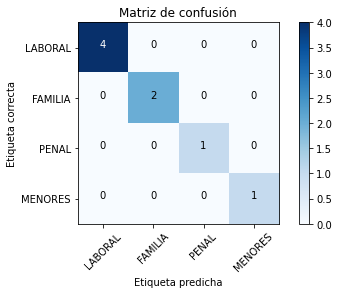

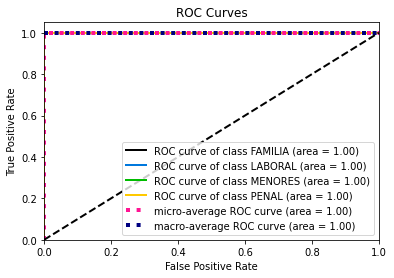

In [227]:
# Logistic Regression 

params = {
    'C': 0.5, # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
    'fit_intercept':False, # Default=True. Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
    'penalty':'none', # Default=l2. Supported penalties: ‘newton-cg’ - [‘l2’, ‘none’]
    'solver': 'newton-cg' # For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss
}

model = LogisticRegression(**params)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
    
show_results(y_val, y_pred, y_prob, classes)